In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        ## Normalizing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [ ]:
image_size = 640
train_path = "C:/Users/NIT/Downloads/UnetFinal Data/"
epochs = 50
batch_size = 32

train_ids = next(os.walk(train_path))[1]

val_data_size = 52


valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(32, 640, 640, 3) (32, 640, 640, 1)


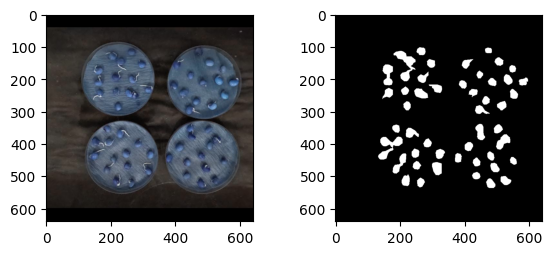

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
import keras

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet(image_size=128):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(2, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


## Different Convolutional Blocks

In [ ]:
model = UNet(640)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 640, 640, 16  91         ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 640, 640, 16  416        ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

                                                                                                  
 concatenate_3 (Concatenate)    (None, 640, 640, 48  0           ['up_sampling2d_3[0][0]',        
                                )                                 'separable_conv2d_1[0][0]']     
                                                                                                  
 separable_conv2d_16 (Separable  (None, 640, 640, 16  1216       ['concatenate_3[0][0]']          
 Conv2D)                        )                                                                 
                                                                                                  
 separable_conv2d_17 (Separable  (None, 640, 640, 16  416        ['separable_conv2d_16[0][0]']    
 Conv2D)                        )                                                                 
                                                                                                  
 conv2d (C

## UNet Model

## Training the model

In [ ]:
from tensorflow.keras.callbacks import TensorBoard


train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

tensorboard_callback = TensorBoard(log_dir='C:/Users/NIT/Downloads', histogram_freq=1)


model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=epochs)


C:\Users\NIT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
15/15 [==============================] - 1460s 97s/step - loss: 0.34 - accuracy: 0.85 - val_loss: 0.31 - val_accuracy: 0.86
Epoch 2/50
15/15 [==============================] - 1420s 95s/step - loss: 0.31 - accuracy: 0.86 - val_loss: 0.29 - val_accuracy: 0.88
Epoch 3/50
15/15 [==============================] - 1480s 99s/step - loss: 0.29 - accuracy: 0.88 - val_loss: 0.27 - val_accuracy: 0.87
Epoch 4/50
15/15 [==============================] - 1370s 91s/step - loss: 0.28 - accuracy: 0.87 - val_loss: 0.25 - val_accuracy: 0.85
Epoch 5/50
15/15 [==============================] - 1450s 97s/step - loss: 0.27 - accuracy: 0.88 - val_loss: 0.24 - val_accuracy: 0.88
Epoch 6/50
15/15 [==============================] - 1410s 94s/step - loss: 0.25 - accuracy: 0.87 - val_loss: 0.22 - val_accuracy: 0.87
Epoch 7/50
15/15 [==============================] - 1490s 99s/step - loss: 0.23 - accuracy: 0.86 - val_loss: 0.21 - val_accuracy: 0.88
Epoch 8/50
15/15 [==============================] - 139